In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
#read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#build the vocabulary of characters and mappings to/from integers
chars=sorted(list(set(''.join(words)))) #creates a sorted list of unique words
stoi={s:i+1 for i,s in enumerate(chars)} #construct a dictionary where the char is the key and value is 1-based index
stoi['.']=0 #assign 0 to the key, '.' 
itos={i:s for s,i in stoi.items()} #construct a dictionary where the 1-based index is the key and value is a char
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
#build the dataset
block_size=3 #context length: how many characters do we take to predict the next one?
X,Y = [], [] #instantiate lists for inputs to the neural network,X, and target outputs, Y.
for w in words:
    #print(w)
    context = [0] * block_size #assign a 1x3 list
    for ch in w + '.': 
        ix = stoi[ch] #assign corresponding integer to ix
        X.append(context) #append 1x3 list representing the input for the output ix to list X
        Y.append(ix) #append ix representing the output for the input context to list Y
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop context (i.e., slice left most col) and append ix
X = torch.tensor(X) #convert list of lists to PyTorch tensor
Y = torch.tensor(Y) #convert list of lists to PyTorch tensor

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
#build the dataset (version 2)

def build_dataset(words):
    block_size=3 #context length: how many characters do we take to predict the next one?
    X,Y = [], [] #instantiate lists for inputs to the neural network,X, and target outputs, Y.
    for w in words:
        #print(w)
        context = [0] * block_size #create a 1x3 list
        for ch in w + '.': 
            ix = stoi[ch] #assign corresponding integer to ix
            X.append(context) #append 1x3 list representing the input for the output ix to list X
            Y.append(ix) #append ix representing the output for the input context to list Y
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop context (i.e., slice left most col) and append ix
    X = torch.tensor(X) #convert list of lists to PyTorch tensor
    Y = torch.tensor(Y) #convert list of lists to PyTorch tensor
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42) #initialize the random number generator with seed value, 42 to ensure reproducibility of calls of random's functions
random.shuffle(words) #randomly rearrange the words in words
n1 = int(0.8*len(words)) #assign 80% of the characters in the dataset
n2 = int(0.9*len(words)) #assign 90% of the characters in the dataset

Xtr, Ytr = build_dataset(words[:n1]) #build training dataset using the first 80% of the characters in the original dataset
Xdev, Ydev = build_dataset(words[n1:n2]) #build development dataset using the next 10% of the characters in the original dataset
Xte, Yte = build_dataset(words[n2:]) #build test dataset using the remaining 10% of the characters in the original dataset
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn([27,2]) #assign to C a tensor filled with random numbers drawn from a normal distribution and with shape 27 rows, 2 cols

In [9]:
emb = C[X] #create an embedding, emb, a new tensor that consists of the rows of C specified by the indices in X (e.g., [0,0,5] accesses row 0, 0, 5 of C
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6,100)) #weight matrix for a hidden layer with 2*3=6 inputs and 100 neurons
b1 = torch.randn(100) #bias vector for the hidden layer with 100 neurons

In [11]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #reshape emb into a 2D tensor with 6 columns, multiply it and the weight matrix, sum the result and the bias to allow for better learning and flexibility, and finally apply hyperbolic tangent activation function to the result

In [12]:
h.shape

torch.Size([228146, 100])

In [13]:
W2 = torch.randn((100,27)) #weight matrix for the final layer with 100 inputs and 27 neurons
b2 = torch.randn(27) #bias vector for the final layer with 27 neurons

In [14]:
logits = h @ W2 + b2 #compute the output of the final layer (i.e., the unnormalized scores output by a neural network priorto applying an activation function like softmax)

In [15]:
logits.shape

torch.Size([228146, 27])

In [16]:
counts = logits.exp() #compute the exponential of each element so that they can be interpreted as counts or probabilities (a.k.a fake counts) since result be positive and differences more pronounced

In [17]:
prob = counts / counts.sum(1, keepdims=True) #normalize the counts tensor to convert it into probabilities

In [18]:
prob.shape

torch.Size([228146, 27])

In [19]:
loss = -prob[torch.arange(228146), Y].log().mean() #negative log of the predicted probabilities of the true class/labels for the sample (i.e., the correct answers that the model is trying to predict)
loss

tensor(15.6798)

In [20]:
# ------------- new made respectable :) -------------

In [21]:
Xtr.shape, Ytr.shape #dateset

(torch.Size([182625, 3]), torch.Size([182625]))

In [22]:
g = torch.Generator().manual_seed(2147483649) #for reproducibility
C = torch.randn((27,10), generator=g) #assign to C a tensor filled with random numbers drawn from a normal distribution and with shape 27 rows, 10 cols
W1 = torch.randn((30, 200), generator=g) #weight matrix for a hidden layer with 30 inputs and 200 neurons
b1 = torch.randn(200, generator=g) #bias vector for the hidden layer with 200 neurons
W2 = torch.randn((200, 27), generator=g) #weight matrix for the final layer with 200 inputs and 27 neurons
b2 = torch.randn(27, generator=g) #bias vector for the final layer with 27 neurons
parameters = [C,W1,b1,W2,b2] # list of all parameters (input tensor, weights, and biases) for the model

In [23]:
sum(p.nelement() for p in parameters) #number of parameters in total

11897

In [24]:
for p in parameters:
    p.requires_grad = True #enable gradient tracking for these tensors, which is essential for backpropagation during training

In [25]:
lre = torch.linspace(-3, 0, 1000) #create a tensor of 1000 evenly spaced values between -3 and 0
lrs = 10**lre #raise each value in lre and raise 10 to the power of that value

In [26]:
#lri = []
lossi = [] #instantiate list to track loss values during training
stepi = [] #instatiate list to track training steps where one step represents each time the model processes a batch of training data and updates its parameters based on the computed gradients

In [27]:
for i in range(200000):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) #create a tensor containing 32 random indices to be used to sample rows from Xtr
    
    #forward pass
    emb = C[Xtr[ix]] #create a (32,3,2) embedding, emb, a new tensor that consists of the rows of C specified by the indices in Xtr[ix]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) #(32,100) #reshape emb into a 2D tensor with 30 columns, multiply it and the weight matrix, sum the result and the bias to allow for better learning and flexibility, and finally apply hyperbolic tangent activation function to the result
    logits = h @ W2 + b2 #(32,27) #compute the output of the final layer (i.e., the unnormalized scores output by a neural network priorto applying an activation function like softmax)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) #negative log of the predicted probabilities of the true class/labels for the sample (i.e., the correct answers that the model is trying to predict)
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None #clear the gradients of the parameter before performing a new optimization in order to avoid incorrect updates
    loss.backward() #perform backpropagation
    
    #update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad #update the parameter p using the calculated gradients where lr is what controls how much to change the parameter and the negative sign indicates a move in the direction opposite that of the gradient
    
    #track stats
    #lri.append(lre)
    stepi.append(i) #add current step to the list tracking training steps
    lossi.append(loss.log10().item()) #add the log 10 of the current loss value

#print(loss.item())

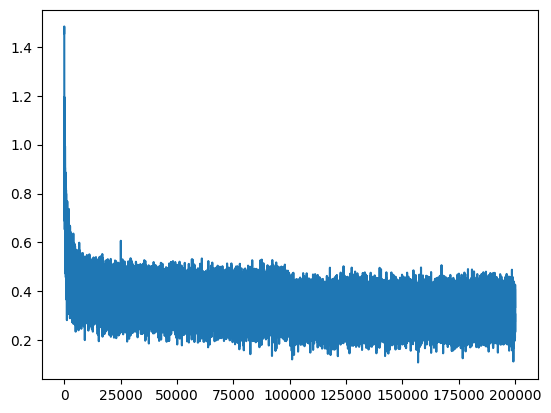

In [28]:
plt.plot(stepi, lossi)

In [29]:
emb = C[Xtr] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #(32, 100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1170, grad_fn=<NllLossBackward0>)

In [30]:
emb = C[Xdev] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #(32, 100)
logits = h @ W2 + b2 #(32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1509, grad_fn=<NllLossBackward0>)

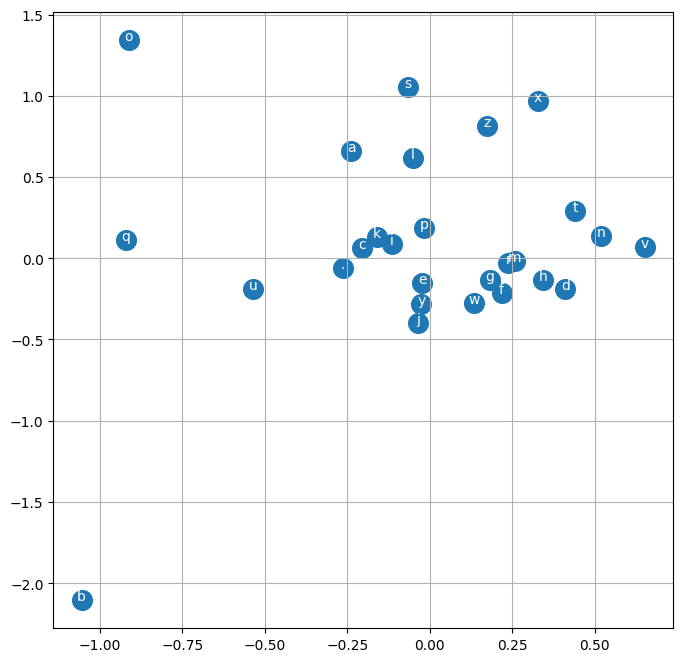

In [31]:
#visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", color='white')
plt.grid('minor')

In [32]:
#training split, dev/validation split, test split
#80%, 10%, 10%


In [33]:
#sample from the model
g = torch.Generator().manual_seed(2147483649 + 10) #for reproducibility

for _ in range(20):
    out = [] #instantiate list to store sampled indices
    context = [0] * block_size #initialize with all ...
    while True:
        emb = C[torch.tensor([context])] #(1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) #apply the softmax function which will transform the raw scores (logits) into probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() #sample an index from the specified probability distribution
        context = context[1:] + [ix] #crop context (i.e., slice left most col) and append ix
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

zahana.
karikson.
xaci.
cerlee.
wan.
sha.
keyah.
tevulei.
preyde.
jata.
uruan.
briyah.
josa.
appi.
avin.
zakarleifin.
rayne.
tatalanaviod.
maelah.
anha.
